**Sistem Deteksi Masker**

Dataset: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection

# **Impor Library dan Dependencies**

In [ ]:
# Impor library yang dibutuhkan
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
import pickle
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [ ]:
!pip install -q kaggle

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fauzanbyu","key":"6315917ff5833a191af787ea7c399e2b"}'}

# **Memuat Dataset**

In [ ]:
!mkdir FaceMaskDetection
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/face-mask-detection -p /content/FaceMaskDetection/

 99% 394M/398M [00:03<00:00, 146MB/s]
100% 398M/398M [00:03<00:00, 111MB/s]


In [ ]:
!unzip /content/FaceMaskDetection/face-mask-detection.zip -d /content/FaceMaskDetection/

Archive:  /content/FaceMaskDetection/face-mask-detection.zip
  inflating: /content/FaceMaskDetection/annotations/maksssksksss0.xml  
  inflating: /content/FaceMaskDetection/annotations/maksssksksss1.xml  
  inflating: /content/FaceMaskDetection/annotations/maksssksksss10.xml  
  inflating: /content/FaceMaskDetection/annotations/maksssksksss100.xml  
  inflating: /content/FaceMaskDetection/annotations/maksssksksss101.xml  
  inflating: /content/FaceMaskDetection/annotations/maksssksksss102.xml  
  inflating: /content/FaceMaskDetection/annotations/maksssksksss103.xml  
  inflating: /content/FaceMaskDetection/annotations/maksssksksss104.xml  
  inflating: /content/FaceMaskDetection/annotations/maksssksksss105.xml  
  inflating: /content/FaceMaskDetection/annotations/maksssksksss106.xml  
  inflating: /content/FaceMaskDetection/annotations/maksssksksss107.xml  
  inflating: /content/FaceMaskDetection/annotations/maksssksksss108.xml  
  inflating: /content/FaceMaskDetection/annotations/maks

Berdasarkan informasi dari penyedia dataset [Kaggle](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection). Terdapat dua folder pada dataset ini, yaitu "images" dan "annotations". Pada folder "images" terdapat sebanyak 853 gambar wajah manusia yang termasuk dalam 3 kelas, yaitu:
- without_mask = Kumpulan gambar wajah manusia yang tidak menggunakan masker.
- with_mask = Kumpulan gambar wajah manusia yang menggunakan masker.
- mask_weared_incorrect = Kumpulan gambar wajah manusia yang salah menggunakan masker.

Sedangkan folder "annotations" pada dataset ini berisi
file anotasi dalam format PASCAL VOC (Visual Object Classes)
yang menyediakan informasi tentang lokasi kotak pembatas
(bounding box) dari objek wajah manusia dan penandaan
apakah objek tersebut menggunakan, tidak menggunakan,
atau salah menggunakan masker.

# **Parsing Anotasi**

Membaca lokasi direktori dataset, dan label kategori (annotations).

In [ ]:
annotations_dir = '/content/FaceMaskDetection/annotations/'
images_dir = '/content/FaceMaskDetection/images/'

Membaca file anotasi XML untuk mendapatkan informasi tentang lokasi bounding box penggunaan masker dan label kategori.

In [ ]:
label2category = {'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 2}
category2label = {0: 'Tidak Menggunakan Masker', 1: 'Menggunakan Masker', 2: 'Salah Menggunakan Masker'}
datas = []

for root, dirs, files in os.walk(annotations_dir):
    for file in files:
        # Membaca dan mem-parse file XML
        tree = ET.parse(os.path.join(root, file))
        data = {'path': None, 'objects': []}
        data['path'] = os.path.join(images_dir, tree.find('filename').text)

        objects = []
        # Membaca setiap objek dalam file XML
        for obj in tree.findall('object'):
            label = label2category[obj.find('name').text]
            # Mendapatkan koordinat kotak pembatas objek
            # koordinat kiri atas
            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            # koordinat kanan bawah
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)
            # Membuat daftar objects yang berisi informasi tentang setiap objek dalam file XML
            objects.append([label, xmin, ymin, xmax, ymax])

        data['objects'] = objects
        datas.append(data)

print('Total images :', len(datas))

Total images : 853


Menampilkan gambar dengan bounding boxes secara acak untuk visualisasi.

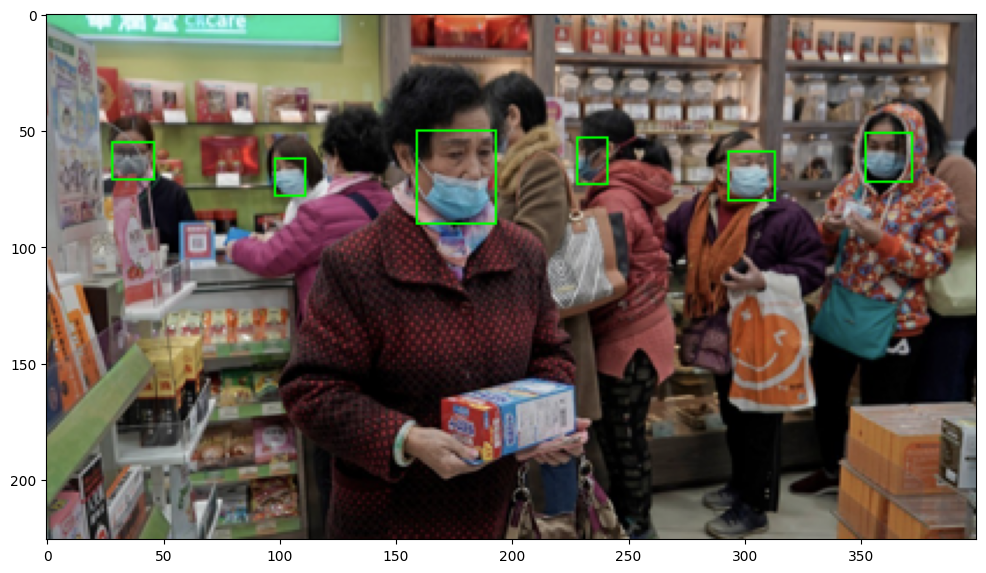

In [ ]:
# Menampilkan gambar dengan bounding boxes
index = np.random.randint(0, len(datas))
img = cv2.imread(datas[index]['path'])

for obj in datas[index]['objects']:
    category, xmin, ymin, xmax, ymax = obj

    # Menggambar kotak pembatas pada gambar
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)

# Menampilkan gambar
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# **Data Preprocessing**

Melakukan cropping dan resize gambar wajah berdasarkan bounding box dengan tujuan membantu mempercepat proses pelatihan dan mengurangi kompleksitas model. Kemudian melakukan konversi label kategori menjadi representasi kategorikal untuk memungkinkan model untuk memahami dan memproses informasi kategori sebagai input numerik, yang diperlukan dalam konteks pelatihan jaringan saraf.

In [ ]:
# Preprocessing
img_size = (100, 100)
X = []
Y = []

for data in datas:
    img = cv2.imread(data['path'])

    objects = data['objects']
    for obj in objects:
        category, xmin, ymin, xmax, ymax = obj

        # Cropping
        roi = img[ymin:ymax, xmin:xmax]   # memotong area ROI dari gambar
        roi = cv2.resize(roi, img_size)   # mengubah ukuran gambar menjadi 100 x 100
        data = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)   # mengonversi format warna gambar BGR (OpenCV) ke RGB

        # Mengonversi label kategori menjadi representasi kategorikal
        target = to_categorical(category, num_classes=len(category2label))

        # Mengumpulkan data gambar dan label kategorikal dalam array X dan Y
        X.append(data)
        Y.append(target)

X = np.array(X)
Y = np.array(Y)

print(X.shape, Y.shape)

(4072, 100, 100, 3) (4072, 3)


Membuat pemetaan label kategori untuk digunakan dalam prediksi setelah model dilatih dan menyimpannya dalam format pickle.

In [ ]:
with open('label_prediksi.pkl', 'wb') as pf:
    pickle.dump(category2label, pf)

# **Model Development**

Memanfaatkan pengetahuan yang telah dipelajari oleh model pada dataset yang besar dan bervariasi dengan menggunakan teknik Transfer Learning dari pre-trained model InceptionV3 dengan pre-trained weights dari dataset ImageNet.

In [ ]:
# Menggunakan pre-trained model InceptionV3
pre_trained_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(100, 100, 3))
summary = pre_trained_model.summary()
print(summary)

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 49, 49, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 49, 49, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

Menambahkan lapisan tambahan di atas pre-trained model untuk menyesuaikan arsitektur model dalam menangkap informasi yang lebih relevan dengan deteksi masker. Lapisan tambahan ini berperan dalam mengekstrak fitur-fitur khusus yang diperlukan untuk tugas deteksi masker.

Kemudian memastikan bahwa hanya lapisan tambahan yang akan mengalami penyesuaian bobot selama pelatihan (layer.trainable = False). Hal ini membantu mencegah kehilangan pengetahuan yang telah dimiliki pre-trained model pada dataset ImageNet.

In [ ]:
# Menambahkan lapisan tambahan di atas pre-trained model
for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_layer_output = last_layer.output

print('Last layer output shape:', last_layer.output_shape)

Last layer output shape: (None, 4, 4, 768)


Menggabungkan pre-trained model dengan lapisan-lapisan tambahan menjadi sebuah model baru.

In [ ]:
# Membangun lapisan tambahan
x = tf.keras.layers.Flatten()(last_layer_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

# Menggabungkan pre-trained model InceptionV3 dengan lapisan-lapisan yang tambahan menjadi sebuah model baru
model = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=x)

summary = model.summary()
print(summary)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 49, 49, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 49, 49, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 49, 49, 32)           0         ['batch_normalization[0][0

Melakukan kompilasi model dengan optimizer Adam dan categorical crossentropy sebagai fungsi loss. Karena pada proyek deteksi masker ini memiliki tiga kelas yang bersifat eksklusif (tidak menggunakan masker, menggunakan masker, salah menggunakan masker). Oleh karena itu, categorical crossentropy cocok untuk tugas klasifikasi multi-kelas.

In [ ]:
# Melakukan kompilasi (compile) model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# **Training Model**

Melakukan normalisasi data gambar dengan membagi nilainya dengan 255 untuk mengubah rentang nilai piksel dalam gambar menjadi skala antara 0 dan 1 sehingga memudahkan proses pembelajaran model dalam jaringan saraf.

In [ ]:
# Normalisasi
X = X / 255.

Membagi dataset menjadi data latih dan data uji (80% data latih, 20% data uji). Data latih digunakan untuk pelatihan model, sedangkan data uji digunakan untuk menguji performa dari model yang dibangun.

In [ ]:
# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Melakukan pelatihan model pada data latih.

In [ ]:
history = model.fit(X_train,
                    Y_train,
                    epochs=15,
                    validation_split=0.2)

Epoch 1/15
82/82 [==============================] - 14s 63ms/step - loss: 0.7199 - accuracy: 0.9148 - val_loss: 0.1323 - val_accuracy: 0.9678
Epoch 2/15
82/82 [==============================] - 2s 24ms/step - loss: 0.0998 - accuracy: 0.9689 - val_loss: 0.1669 - val_accuracy: 0.9586
Epoch 3/15
82/82 [==============================] - 2s 23ms/step - loss: 0.0557 - accuracy: 0.9804 - val_loss: 0.1099 - val_accuracy: 0.9632
Epoch 4/15
82/82 [==============================] - 2s 22ms/step - loss: 0.0269 - accuracy: 0.9919 - val_loss: 0.1135 - val_accuracy: 0.9739
Epoch 5/15
82/82 [==============================] - 2s 22ms/step - loss: 0.0166 - accuracy: 0.9942 - val_loss: 0.1599 - val_accuracy: 0.9632
Epoch 6/15
82/82 [==============================] - 2s 22ms/step - loss: 0.0263 - accuracy: 0.9939 - val_loss: 0.1373 - val_accuracy: 0.9709
Epoch 7/15
82/82 [==============================] - 2s 22ms/step - loss: 0.0288 - accuracy: 0.9919 - val_loss: 0.1367 - val_accuracy: 0.9693
Epoch 8/15
8

# **Evaluasi Model**

Memvisualisasikan plot akurasi dan loss selama pelatihan model.

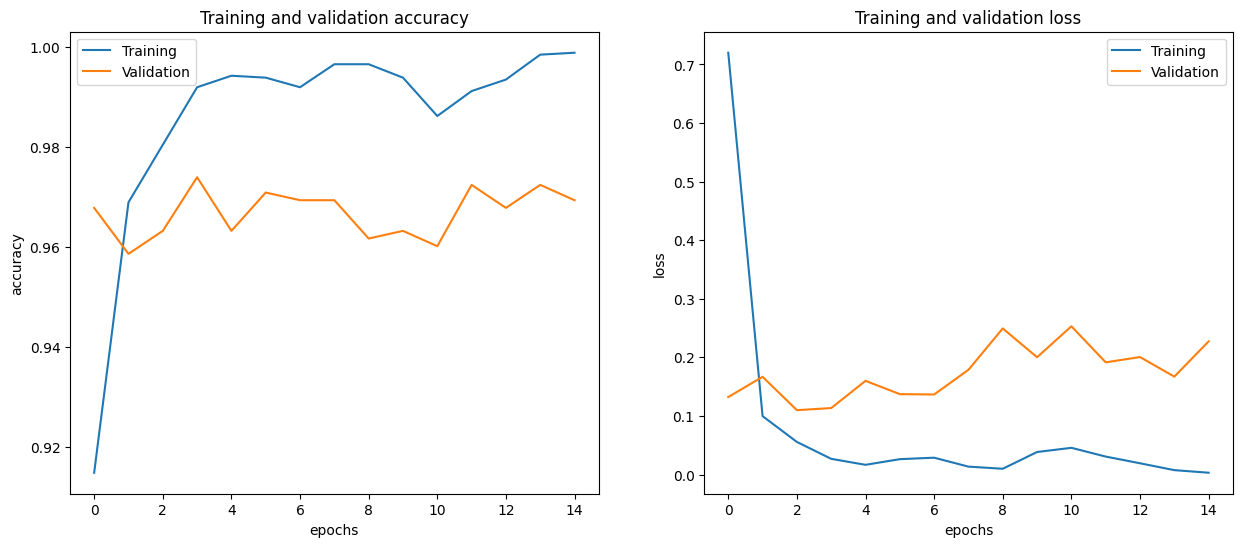

In [ ]:
# Menampilkan plot akurasi dan loss
plt.figure(figsize=(15, 6))

# Plot akurasi
plt.subplot(121)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

# Plot loss
plt.subplot(122)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

Menyimpan model yang telah dilatih dalam file 'training.h5'.

In [ ]:
# Menyimpan model yang telah dilatih
model.save('training.h5')

Evaluasi performa dengan data uji terhadap model yang dibangun dengan menampilkan nilai akurasi dan loss.

In [ ]:
# Mengevaluasi performa model dengan data uji
evaluation_results = model.evaluate(X_test, Y_test)

print("")
print("Test Accuracy:", evaluation_results[1])
print("Test Loss    :", evaluation_results[0])

26/26 [==============================] - 1s 20ms/step - loss: 0.3332 - accuracy: 0.9595

Test Accuracy: 0.9595091938972473
Test Loss    : 0.3331829011440277


Berdasarkan output diatas, dapat diketahui bahwa model memiliki akurasi pada data uji sebesar 96%, dan loss pada data uji sebesar 0.33.

Setelah menyimpan pemetaan label kategori sebagai 'label_prediksi.pkl' dan menyimpan model yang telah dilakukan pelatihan sebagai 'training.h5', maka model telah siap untuk tahap deployment.